In [ ]:
# Uncomment these lines if you have not installed any packages yet
# !pip install vislearnlabpy
# !pip install git+https://github.com/openai/CLIP.git
# !pip install torch torchvision torchaudio

To open in Google CoLab: https://colab.research.google.com/github/vislearnlab/vllpy/blob/main/examples/drawings/embedding_analysis.ipynb

In [1]:
from vislearnlabpy.embeddings.generate_embeddings import EmbeddingGenerator
from vislearnlabpy.embeddings.embedding_store import EmbeddingStore
from vislearnlabpy.embeddings.utils import display_search_results, zscore_embeddings 
import numpy as np
import pandas as pd
import os
from pathlib import Path

/opt/miniconda3/envs/vllpy/lib/python3.11/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
SAVE_DIR = Path(os.getcwd()) / "mongo_output" # often set to /Volumes/vislearnlab/experiments/drawings/data..
drawings_df = pd.read_csv(Path(SAVE_DIR / "AllDescriptives_images_final_birch_run_v1.csv"))

In [8]:
#make sure the filename field is pointing to the right location, this is very important. Otherwise you will have to do some string manipulation to make sure it is
drawings_df.head() 

,session_id,trial_num,category,participantID,filename,submit_time,submit_date,submit_date_readable,start_time,trial_duration,num_strokes,draw_duration,mean_intensity,bounding_box
0,cdm_run_v81751572998320,2,square,Aj001,/Users/visuallearninglab/Documents/vllpy/examp...,1.751573e+12,2025-07-03T20:08:34.631Z,2025-07-03 13:08:34.631000,1.751573e+12,11.518,1,6.222,0.013652,"(np.int64(55), np.int64(163), np.int64(43), np..."
1,cdm_run_v81751572998320,3,shape,Aj001,/Users/visuallearninglab/Documents/vllpy/examp...,1.751573e+12,2025-07-03T20:09:16.334Z,2025-07-03 13:09:16.334000,1.751573e+12,14.430,1,9.650,0.015525,"(np.int64(0), np.int64(215), np.int64(23), np...."
2,cdm_run_v81751572998320,4,this_square,Aj001,/Users/visuallearninglab/Documents/vllpy/examp...,1.751573e+12,2025-07-03T20:09:37.053Z,2025-07-03 13:09:37.053000,1.751573e+12,13.693,3,3.407,0.011460,"(np.int64(47), np.int64(140), np.int64(56), np..."
3,cdm_run_v81751572998320,6,a_shark,Aj001,/Users/visuallearninglab/Documents/vllpy/examp...,1.751573e+12,2025-07-03T20:11:15.066Z,2025-07-03 13:11:15.066000,1.751573e+12,21.236,9,14.274,0.018654,"(np.int64(52), np.int64(151), np.int64(1), np...."
4,cdm_run_v81751572998320,8,a_crab,Aj001,/Users/visuallearninglab/Documents/vllpy/examp...,1.751574e+12,2025-07-03T20:12:37.435Z,2025-07-03 13:12:37.435000,1.751574e+12,27.682,10,14.633,0.017997,"(np.int64(68), np.int64(183), np.int64(38), np..."


In [16]:
def remap_path(full_path, new_base):
    """
    Given a full path to a file and a new base directory, returns a new path
    that keeps only the parent and grandparent directories of the file, prepended by new_base.

    Example:
        Input:
            full_path = ".../mongo_output/sketches_full_dataset/square/image.png"
            new_base = "/mnt/data/output"

        Output:
            Path("/mnt/data/output/square/image.png")
    """
    original = Path(full_path)
    parent = original.parent.name            # e.g. "a_shark"
    
    return str(Path(new_base) / parent / original.name)

In [9]:
# renaming columns in the format our embedding generator expects them to be in
drawings_df = drawings_df.rename(columns={
    'filename': 'image1',
    'category': 'text1'
})
# getting rid of articles
drawings_df['text1'] = drawings_df['text1'].apply(lambda x: x.split('_')[-1])

#remap path if needed: new_base="/file/storage/path"
#drawings_df["image1"] = drawings_df["image1"].apply(lambda x: remap_path(x, new_base))

# Filtering to just our actual participants
filtered_df = drawings_df[drawings_df['participantID'].str.lower().str.contains('bd')]
filtered_df.to_csv("tmp_draw_df.csv")

Our embedding generator

In [25]:
# change device="cuda" or "cuda:2" etc if you are using with GPU
clip_generator = EmbeddingGenerator(model_type="clip", device="cpu", output_type="doc") 
# setting text prompt to "a drawing of a xx" will make sure CLIP knows it's looking at drawings
clip_generator.model.text_prompt = "a drawing of a"

We're storing our embeddings in DocArray lists so that they are accessible and loadable from a single file and are directly linked to their file paths and category names

In [ ]:
clip_generator.generate_image_embeddings(output_path="sketch_embeddings", input_csv="tmp_draw_df.csv", batch_size=100, id_column="image1", overwrite=True)

Loading our image embeddings and text embeddings

In [3]:
image_embedding_store = EmbeddingStore.from_doc("sketch_embeddings/image_embeddings/clip_image_embeddings_doc.docs")
text_embedding_store = EmbeddingStore.from_doc("sketch_embeddings/text_embeddings/clip_text_embeddings_doc.docs")

/opt/miniconda3/envs/vllpy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

An RDM at the category level.

In [4]:
image_embedding_store.compute_text_rdm(output_path="rdm")


...Output directory did not exists. Creating directories.



array([[0.00000000e+00, 2.79111862e-02, 1.10335350e-02, 3.01397443e-02,
        2.65619159e-02, 7.63664842e-02, 2.79201269e-02, 6.78842068e-02,
        1.72900558e-02, 1.97846293e-02],
       [2.79111862e-02, 0.00000000e+00, 3.24439406e-02, 4.39851284e-02,
        1.80369616e-02, 6.75517321e-02, 1.21345520e-02, 6.24303222e-02,
        1.53005123e-02, 8.49807262e-03],
       [1.10335350e-02, 3.24439406e-02, 0.00000000e+00, 3.00901532e-02,
        3.30119729e-02, 7.33634233e-02, 3.76954079e-02, 7.73026943e-02,
        2.28877068e-02, 2.77327299e-02],
       [3.01397443e-02, 4.39851284e-02, 3.00901532e-02, 0.00000000e+00,
        3.95927429e-02, 9.37950015e-02, 4.16791439e-02, 9.88795161e-02,
        3.34191322e-02, 3.29193473e-02],
       [2.65619159e-02, 1.80369616e-02, 3.30119729e-02, 3.95927429e-02,
        0.00000000e+00, 5.16197681e-02, 2.28781700e-02, 5.20437360e-02,
        1.82853341e-02, 1.90573335e-02],
       [7.63664842e-02, 6.75517321e-02, 7.33634233e-02, 9.37950015e-02,
   

Just sanity checking that our text embeddings look like we expect them to.

In [3]:
text_embedding_store.EmbeddingList.text

['turtle',
 'shape',
 'seahorse',
 'octopus',
 'penguin',
 'shark',
 'fish',
 'crab',
 'square',
 'whale']

Search through our embedding store for 'sharks' 

In [ ]:
docs, scores = image_embedding_store.search_store(text_query="shark", limit=10)
display_search_results(docs, scores)

Now only using drawings that were originally labeled as shark

In [ ]:
docs, scores = image_embedding_store.search_store(text_query="shark", limit=10, categories=["shark"])
display_search_results(docs, scores)

Now see how recognizable different images are

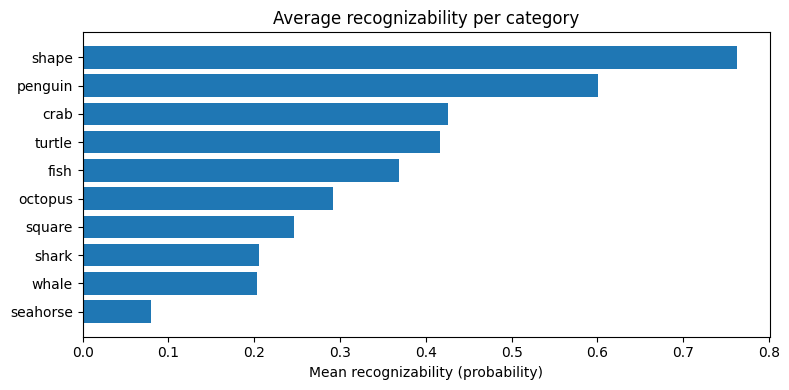

In [44]:
from vislearnlabpy.embeddings.similarity_utils import calculate_accuracy
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

records = []
for doc in image_embedding_store.EmbeddingList:
    acc = calculate_accuracy(
        doc.embedding,
        text_embedding_store.EmbeddingList,
        doc.text
    )
    records.append(
        {
            "category": doc.text,
            "accuracy": acc,
            "url": doc.url,          # can calculate age etc. here from ID extracted from URL
        }
    )
df = pd.DataFrame(records)
mean_df = (
    df.groupby("category", as_index=False)["accuracy"]
      .mean()
      .query("accuracy > 0")          # keep positives only
      .sort_values("accuracy")        # ascending for barh order
)
plt.figure(figsize=(8, max(4, len(mean_df) * 0.25)))
plt.barh(mean_df["category"], mean_df["accuracy"]) # horizontal for readable labels
plt.xlabel("Mean recognizability (probability)")
plt.title("Average recognizability per category")
plt.tight_layout()
plt.show()

Save embeddings and recognizability values as CSV files for processing in R etc.

In [42]:
text_embedding_store.to_base_csv("sketch_embeddings/text_embeddings/clip_text_embeddings.csv")
image_embedding_store.to_base_csv("sketch_embeddings/image_embeddings/clip_image_embeddings.csv")
df.to_csv("recognizability.csv")

Z-score embeddings before saving if needed

In [43]:
image_embedding_store.EmbeddingList.normalized_embedding = zscore_embeddings(np.stack(image_embedding_store.EmbeddingList.embedding))
# image_embedding_store.EmbeddingList.embedding = image_embedding_store.EmbeddingList.normalized_embedding
# image_embedding_store.to_base_csv("sketch_embeddings/image_embeddings/clip_image_embeddings.csv")